Course: Deep Learning

Author: Sandro Camargo sandrocamargo@unipampa.edu.br

Using LSTM to predict a time series

AirPassengers: Monthly Airline Passenger Numbers 1949-1960

Dataset: https://github.com/jbrownlee/Datasets/blob/master/airline-passengers.csv

Dataset description: 


In [18]:
# Loading libraries
import pandas as pd  # Data Importing
import numpy as np    # Fast Numerical Computations
import matplotlib.pyplot as plt   # Plots
from keras.models import Sequential   # Neural network models
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler    # Scaler
from sklearn.metrics import mean_squared_error

In [19]:
def create_dataset(dataset, lookback=1):
    dataX = []
    dataY = []
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i: (i+lookback), 0]
        dataX.append(a)
        dataY.append(dataset[i+lookback,0])
    return np.array(dataX), np.array(dataY)

In [20]:
# Importing dataset 
data = "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"

np.random.seed(1)

dataset = pd.read_csv(data, usecols=[1])
dataset = dataset.dropna()    # Remove empty lines

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [22]:
# Split data in training and testing sets
train_dataset = dataset[:int(len(dataset)*0.8), :]
test_dataset = dataset[int(len(dataset)*0.8):, :]

lookback = 1
train_x, train_y = create_dataset(train_dataset, lookback)
test_x, test_y = create_dataset(test_dataset, lookback)

train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

print('The training dataset (inputs) dimensions are: ', train_x.shape)
print('The training dataset (outputs) dimensions are: ', train_y.shape)
print('The testing dataset (inputs) dimensions are: ', test_x.shape)
print('The testing dataset (outputs) dimensions are: ', test_y.shape)

The training dataset (inputs) dimensions are:  (113, 1, 1)
The training dataset (outputs) dimensions are:  (113,)
The testing dataset (inputs) dimensions are:  (27, 1, 1)
The testing dataset (outputs) dimensions are:  (27,)


In [23]:
model = Sequential()
model.add(LSTM(5, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss='mse', 
    optimizer='adam', 
    metrics=['mse','mae'])

In [24]:
model.summary()
history = model.fit(train_x, train_x, epochs=20, batch_size=1, verbose=1, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5)                 140       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
90/90 [==============================] - 2s 8ms/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1325 - val_loss: 0.1206 - val_mse: 0.1206 - val_mae: 0.3357
Epoch 2/20
90/90 [==============================] - 0s 2ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0904 - val_loss: 0.0790 - val_mse: 0.0790 - val_mae: 0.2679
Epoch 3/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0836 - val_loss: 0.0609 - 

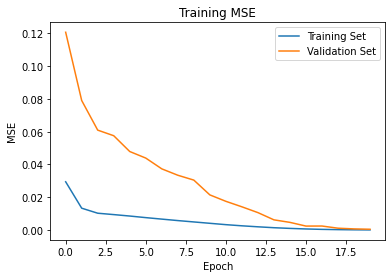

Training MSE:  7.686324534006417e-05
Validation MSE:  0.00048481483827345073


In [25]:
# Plot loss function for training and validation sets
plt.plot(history.history['mse'], label="Training Set")
plt.plot(history.history['val_mse'], label="Validation Set")
plt.title('Training MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig("lstm-regr-lossfunction.pdf")
plt.show()
print("Training MSE: ", history.history['mse'][-1])
print("Validation MSE: ", history.history['val_mse'][-1])

1/1 [==============================] - 0s 381ms/step


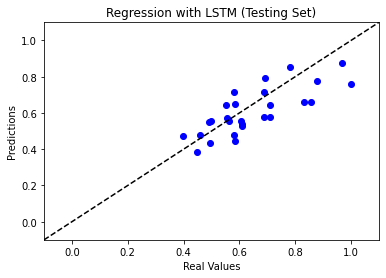

Correlation Coefficient in testing set: 0.7771


In [26]:
# make predictions
testPredict = model.predict(test_x)

plt.scatter(test_y, testPredict, marker = 'o', c = 'blue')
plt.plot([-0.1,1.1], [-0.1,1.1], color = 'black', ls = '--')
plt.ylabel('Predictions')
plt.xlabel('Real Values')
plt.title('Regression with LSTM (Testing Set)')
plt.ylim(-0.1, 1.1)
plt.xlim(-0.1, 1.1)
plt.axis(True)
plt.savefig("lstm-regr-testing.pdf")
plt.show()

print("Correlation Coefficient in testing set: %.4f" % np.corrcoef(np.transpose(testPredict), np.transpose(test_y))[0,1])

4/4 [==============================] - 0s 3ms/step


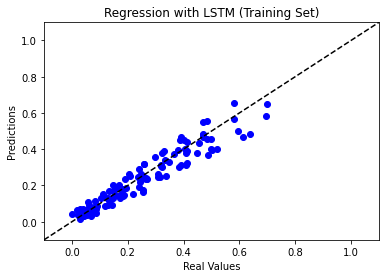

Correlation Coefficient in training set: 0.9550


In [27]:
trainPredict = model.predict(train_x)

plt.scatter(train_y, trainPredict, marker = 'o', c = 'blue')
plt.plot([-0.1,1.1], [-0.1,1.1], color = 'black', ls = '--')
plt.ylabel('Predictions')
plt.xlabel('Real Values')
plt.title('Regression with LSTM (Training Set)')
plt.ylim(-0.1, 1.1)
plt.xlim(-0.1, 1.1)
plt.axis(True)
plt.savefig("lstm-regr-training.pdf")
plt.show()

print("Correlation Coefficient in training set: %.4f" % np.corrcoef(np.transpose(trainPredict), np.transpose(train_y))[0,1])

In [28]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
train_y = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(testPredict)
test_y = scaler.inverse_transform([test_y])

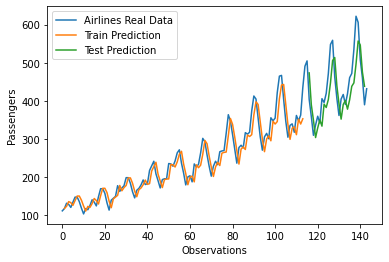

In [29]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lookback*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label="Airlines Real Data")
plt.plot(trainPredictPlot, label="Train Prediction")
plt.plot(testPredictPlot, label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.savefig("lstm-regr-result.pdf")
plt.show()
